# GP-GAN for image blending
As described in paper: Gp-gan: Towards realistic high-resolution image blending

In [1]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
COCO_ROOT = 'D:/Datasets/COCO/'
COCO_SET = 'train2017'
import sys
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)
import tensorflow as tf
from threading import Thread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import time
from keras.layers import *
import keras
from keras.models import *
from IPython.display import clear_output
import keras.backend as K
import keras.optimizers
import datasets
import composition
from pycocotools.coco import COCO

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


LEye is not present
REye is not present
LEar is not present
REar is not present
Nose is not present
Background is not present
HeadTop is not present
Neck is not present
Chest is not present
Pelvis is not present
Background is not present


In [2]:
# DISCRIMINATOR
vgg19 = keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(64,64,3), 
    pooling=None)

# DISCRIMINATOR MODEL
x = vgg19.output
x = Flatten()(x)
x = Dense(1, kernel_initializer='he_uniform')(x)
dis_model = Model(vgg19.input, x)


# GENERATOR
def encoder(x):
    # THIS IS BASICALLY THE ALEXNET ENCODER TAKEN FROM POOl5
    x = Conv2D(64, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2D(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2D(256, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2D(512, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = Flatten()(x)
    x = Dense(4000, activation='relu', kernel_initializer='he_uniform')(x)
    return x

def decoder(x):
    # HERE ARE ARE GOING TO DO UPSAMPLING + CONVOLUTION
    x = Reshape((1,1,4000))(x)
    x = Conv2DTranspose(512, kernel_size=(4,4), strides=(1,1), activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2DTranspose(256, padding='same', kernel_size=(4,4), strides=(2,2), activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2DTranspose(128, padding='same', kernel_size=(4,4), strides=(2,2), activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2DTranspose(64, padding='same', kernel_size=(4,4), strides=(2,2), activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2DTranspose(3, padding='same', kernel_size=(4,4), strides=(2,2), kernel_initializer='he_uniform')(x)
    return x

# GENERATOR MODEL
x = Input((64,64,3)) 
h = encoder(x)
xg = decoder(h)
gen_model = Model(x, xg)

# GAN MODEL
gan_input = x 
gan_output = dis_model( xg )
gan_model = Model(gan_input, gan_output)



In [3]:
dis_model.trainable = False
gan_opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.5)
gan_model.compile(gan_opt, 'mean_absolute_error')

dis_model.trainable = True
dis_opt = keras.optimizers.Adam(lr=0.0001)
dis_model.compile(dis_opt, 'mean_absolute_error')

#gen_opt = keras.optimizers.Adam(lr=0.0002*0.999)
gen_opt = keras.optimizers.Adam(lr=0.0001)
gen_model.compile(gen_opt, 'mean_squared_error')

In [4]:
annFile='{}/annotations/instances_{}.json'.format(COCO_ROOT,COCO_SET)
annFileKPS = '{}/annotations/person_keypoints_{}.json'.format(COCO_ROOT,COCO_SET)
catNms = ['person']
coco=COCO(annFile)
coco_kps=COCO(annFileKPS)  
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )

loading annotations into memory...
Done (t=35.02s)
creating index...
index created!
loading annotations into memory...
Done (t=16.34s)
creating index...
index created!


In [5]:
def get_real_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the real examples thread')
    # GET REFERENCE, NATURAL LOOKING EXAMPLES
    for i in range(0, batch_size):
        IM = composition.get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, catIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'])
        list_out.append(IM)
    print('Real examples done')

def get_fake_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    for i in range(0, batch_size):
        while True:
            data_train = composition.get_composition(coco, coco_kps,coco_root, imgIds, catIds, params=params)
            if data_train is not None:
                list_out.append(data_train)
                break
    print('Fake examples done')
    

def get_training_examples(coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size):
    
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    thread_real.join()
    thread_fake.join()
    return np.array(list_real), np.array(list_fake)



In [ ]:
composition_params = composition.default_composition_params
composition_params['longer_edge_size'] = 256

it = 0
progress = []


It: 48, DIS loss: 0.19216731190681458, GEN loss: 2347.777099609375, GAN loss: 1.2192869186401367


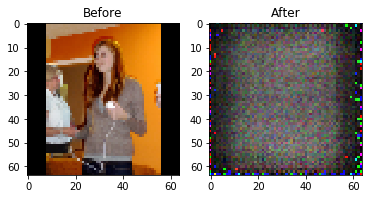

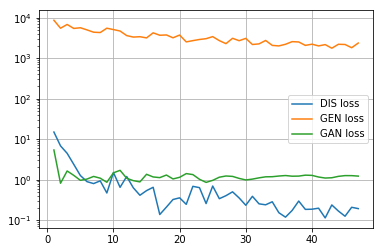

Starting the real examples thread
Starting the fake examples thread
Dis loss cur: 0.10876401513814926
Gen loss cur: 2281.794921875
GAN loss cur: 1.1565216779708862
Real examples done
Fake examples done
Starting the real examples thread
Starting the fake examples thread
Dis loss cur: 0.21906039118766785
Gen loss cur: 2171.9873046875
GAN loss cur: 1.1593942642211914
Real examples done
Fake examples done
Starting the real examples thread
Starting the fake examples thread
Dis loss cur: 0.18033692240715027
Gen loss cur: 2003.7279052734375
GAN loss cur: 1.2626190185546875
Real examples done


In [ ]:
batch_size = 16

while True:

    # Set up the threads to work in the background while running GPU tasks
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()
    
    if it > 0:
        if 0:
            plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
            plt.show()
            plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
            plt.show()

            plt.imshow( examples_fake[0]['image_scaled_and_padded'].astype(np.uint8) )
            plt.show()
            plt.imshow( examples_fake[0]['A']['rect_scaled_and_padded'].astype(np.uint8) )
            plt.show()
            plt.imshow( examples_fake[0]['inserted_mask'].astype(np.uint8) )
            plt.show()


        # CREATE BATCH FOR REAL VS FAKE FOR DISCRIMINATOR
        batch_real_x = np.zeros((batch_size//2, 64,64,3))
        batch_real_y = np.ones((batch_size//2, 1))
        batch_fake_x_in = np.zeros((batch_size//2, 64,64,3))
        batch_fake_y = np.zeros((batch_size//2, 1))
        for i in range(0, batch_size//2):
            batch_real_x[i] = cv2.resize( examples_real[i]['image_scaled_and_padded'], (64,64) )
            batch_fake_x_in[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
        batch_fake_x_out = gen_model.predict(batch_fake_x_in)
        dis_batch_x = np.concatenate([ batch_real_x,batch_fake_x_out ],0)
        dis_batch_y = np.concatenate([ batch_real_y,batch_fake_y ],0)
    
        
        dis_model.trainable = True
        dis_loss_cur = dis_model.train_on_batch(dis_batch_x, dis_batch_y)
        print('Dis loss cur: {}'.format(dis_loss_cur))

        # CREATE BATCH FOR GENERATOR 
        batch_fake_x = np.zeros((batch_size, 64,64,3))
        for i in range(0, batch_size//2):
            batch_fake_x[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
        gen_loss_cur = gen_model.train_on_batch(batch_fake_x, batch_fake_x)
        print('Gen loss cur: {}'.format(gen_loss_cur))


        # GAN TRAINING IN FULL
        dis_model.trainable = False
        gan_loss_cur = gan_model.train_on_batch( batch_fake_x, np.ones((batch_size,1)) )
        print('GAN loss cur: {}'.format(gan_loss_cur))

        progress.append([ it, dis_loss_cur,  gen_loss_cur, gan_loss_cur ])

    # Wait for the threads to stop and store new training data
    thread_real.join()
    thread_fake.join()
    examples_real = np.array(list_real)
    examples_fake = np.array(list_fake)
    
    it += 1
    
    if it % 4 == 0:
        clear_output()
        print('It: {}, DIS loss: {}, GEN loss: {}, GAN loss: {}'.format(it, dis_loss_cur, gen_loss_cur, gan_loss_cur))
        
        plt.subplot(1,2,1)
        plt.imshow(batch_fake_x_in[0].astype(np.uint8))
        plt.title('Before')
        plt.subplot(1,2,2)
        plt.imshow(batch_fake_x_out[0].astype(np.uint8))
        plt.title('After')
        plt.show()
        
        p = np.array(progress)
        p = p[np.max([0, p.shape[0]-100]):,]
        plt.figure()
        plt.semilogy( p[:,0], p[:,1] )
        plt.semilogy( p[:,0], p[:,2] )
        plt.semilogy( p[:,0], p[:,3] )
        plt.grid()
        plt.legend(['DIS loss','GEN loss', 'GAN loss'])
        plt.show()



In [ ]:
print(batch_real_x.shape)

plt.imshow(batch_fake_x[0].astype(np.uint8))
plt.show()
print(batch_real_y.shape)